# Synthetic 1D inversion of Audio Magnetotelluric data


## 0. Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cofi
from cofi_espresso import Magnetotelluric1D

In [2]:
mt = Magnetotelluric1D()

### Create synthetic data given a 5 layers Earth model

#### 0.1. Define a resistivity model and plot it

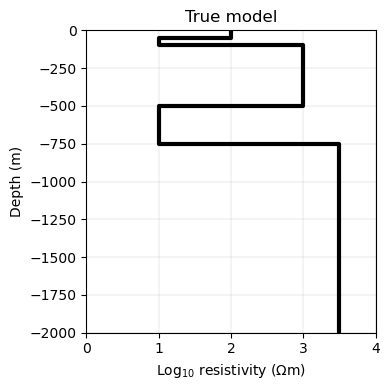

In [3]:
# layer electrical resitivity in log10 ohm.m 
true_model = np.array([2,1,3,1,3.5]) 
# depths in meters to the bottom of each layer (positive downwards), last layer infinite: len(true_depths)+1 = len(true_model)
true_depths = np.array([50,100,500,750])
# plot the model
max_depth=-2000
fig = mt.plot_model(true_model, true_depths, title='True model',max_depth = max_depth)

#### 0.2. Compute response of the model

In [4]:
#Define useful functions
from cofi_espresso._magnetotelluric_1D import get_frequencies, forward_1D_MT, z2rhophy, add_noise

Compute synthetic data, add noise, define the data / errors and plot

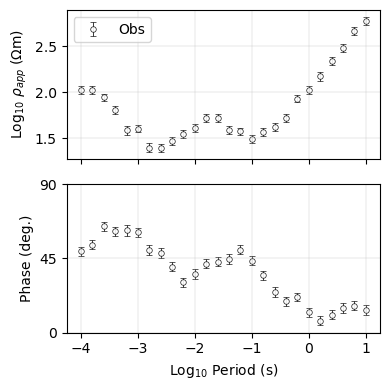

In [5]:
# define frequencies (in Hz) where responses are computed
fmin, fmax, f_per_decade = 1e-1, 1e4, 5
freqs = get_frequencies(fmin,fmax,f_per_decade)
# generate synthetic data 
# calculate impedance Z
Z = forward_1D_MT(true_model, true_depths, freqs, return_Z = True)
# add noise
Z, Zerr = add_noise(Z, percentage = 5, seed = 1234)
# transform Z to log10 apparent resistivity and phase (dobs)
dobs, derr = z2rhophy(freqs, Z, dZ=Zerr)
#set observed data
mt.set_obs_data(dobs, derr, freqs)
# plot the data
fig = mt.plot_data(mt.data, Cm = mt.covariance_matrix)

#### 0.3. Define a starting 1D mesh and model for the inversion

In [6]:
# the mesh used for the inversion contains many cells to produce a smooth model
nLayers, min_thickness, vertical_growth= 80, 5, 1.1
thicknesses = [min_thickness * vertical_growth**i for i in range(nLayers)]
starting_depths = np.cumsum(thicknesses)
starting_model = np.ones((len(starting_depths)+1)) * 2 # 100 ohm.m starting model (log10 scale) 
print('Model bottom: %.2f m'%starting_depths[-1])

Model bottom: 102370.01 m


#### 0.4. Set new starting model and mesh

In [7]:
mt.set_start_model(starting_model)
mt.set_start_mesh(starting_depths)

## 1. Define the problem

In [8]:
# get problem information from  espresso mt
model_size = len(mt.starting_model)         # number of model parameters
data_size = mt.data_size           # number of data points

In [9]:
# define CoFI BaseProblem
mt_problem = cofi.BaseProblem()
mt_problem.set_initial_model(mt.starting_model)

In [10]:
# add regularization: smoothing
smoothing_factor = 10
reg_smoothing = cofi.utils.QuadraticReg(smoothing_factor, model_size = model_size, reg_type = "smoothing")
reg = reg_smoothing
reg.model_size

81

In [11]:
def objective_func(logres, reg, depths = mt._dpstart):
    dpred = mt.forward(logres, depths=depths)
    data_misfit = mt.misfit(mt.data,dpred,mt.inverse_covariance_matrix)
    model_reg = reg(logres)
    return  data_misfit + model_reg

In [12]:
mt_problem.set_objective(objective_func, args=[reg, mt._dpstart])

In [13]:
#mt_problem.summary()

## 2. Define the inversion options

In [14]:
#mt_problem.suggest_tools();

In [15]:
my_options = cofi.InversionOptions()
my_options.set_tool("scipy.optimize.minimize")
my_options.set_params(method="L-BFGS-B",options={'ftol':1e-3,'maxiter': 100})
#my_options.summary()

In [16]:
#my_options.suggest_solver_params()

## 3.1 Start an inversion

In [17]:
inv = cofi.Inversion(mt_problem, my_options)
inv_result = inv.run()
inv_result.summary()

Summary for inversion result
FAILURE
----------------------------
fun: 43.968006844640385
jac: [ 4.6853913  -8.70079907  8.08840218 -2.16904185  0.0405926   0.18856099
 -0.85653583 -1.80651086 -3.41125455 -4.5580222  -0.7748966  -0.35093351
 -1.52983191  0.43460062  0.37975952  0.03624407 -0.05988028 -1.07720482
  0.65840667  0.44885624 -0.66779152  0.20762272 -0.8472874  -0.91850723
 -0.87723038 -4.18859403 -6.84000629 -9.54358873 -8.78902716 -4.43607394
 -3.69221385 -2.21360354 -0.26722518 -1.56271299 -0.91967252  0.8148767
 -0.02472831 -0.64187234 -0.47054627 -0.44644608  0.31573251  0.02014602
 -1.07330678  0.13418884  0.28209044 -1.09858789  0.57983556 -0.0315282
 -1.88739976  1.09422729  0.40339856 -1.23416016  0.93589208 -0.19539286
  0.15866419 -0.33594674 -1.14713075  1.58204899 -0.94342241 -1.07399814
  0.56073688 -1.36061332  0.51781157  1.29898795 -0.01665939  0.2808342
 -1.28351446  0.5255906  -0.02940368 -0.72312006  1.76511606 -0.68960447
 -0.34448462  0.89418962  1.5245

## 3.2 Plot inversion results

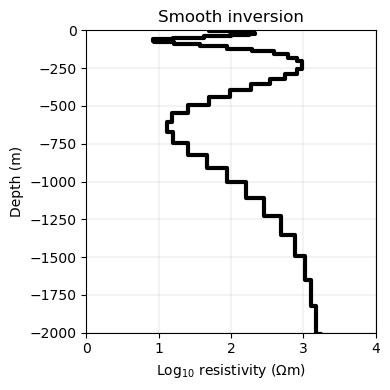

In [18]:
fig1 = mt.plot_model(inv_result.model, depths = mt._dpstart, max_depth = max_depth, title='Smooth inversion');            # inverted model

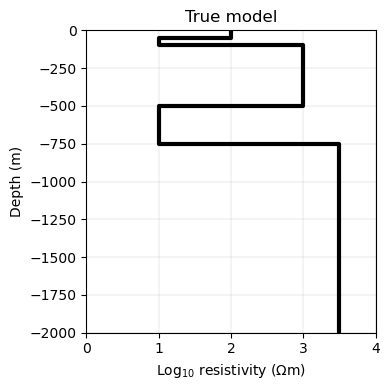

In [19]:
fig2 = mt.plot_model(true_model, true_depths, max_depth = max_depth, title='True model');       # true model

nRMSE = 0.866


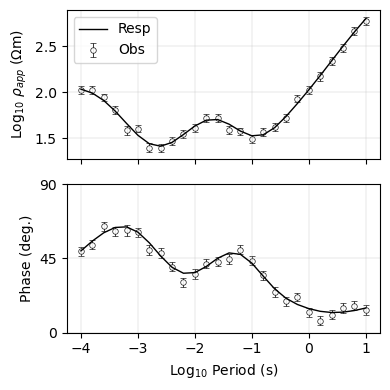

In [20]:
fig = mt.plot_data(mt.data, mt.forward(inv_result.model,depths=mt._dpstart), Cm = mt.covariance_matrix)
nRMSE = np.sqrt(mt.misfit(mt.data, mt.forward(inv_result.model,depths=starting_depths), Cm_inv = mt.inverse_covariance_matrix)/mt.data_size)
print('nRMSE = %.3f'%nRMSE)